# 期末大作业 使用Bert+ViT

In [1]:
%pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import cv2
import random
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## 数据读取与预处理

In [3]:
all_posters_filename = os.listdir('./poster')
all_posters_index = sorted([int(x[:-4]) for x in all_posters_filename])
all_posters_filename = [f'{i}.jpg' for i in all_posters_index]
df_movie_info = pd.read_csv('info.csv', index_col=0).loc[all_posters_index, ['name', 'intro']]
df_movie_info.head(5)

name  \
id                                        
1                     Toy Story (1995)    
2                       Jumanji (1995)    
3              Grumpier Old Men (1995)    
4             Waiting to Exhale (1995)    
5   Father of the Bride Part II (1995)    

                                                intro  
id                                                     
1   A cowboy doll is profoundly threatened and jea...  
2   When two kids find and play a magical board ga...  
3   John and Max resolve to save their beloved bai...  
4   Based on Terry McMillan's novel, this film fol...  
5   George Banks must deal not only with the pregn...

In [4]:
movie_intros = df_movie_info.loc[:, 'intro'].tolist()
movie_names = df_movie_info.loc[:, 'name'].tolist()

Unzipped (1995) 
One of the most successful designers in high fashion plans his fall 1994 collection. Follow the behind-the-scenes look at the creative side of fashion.


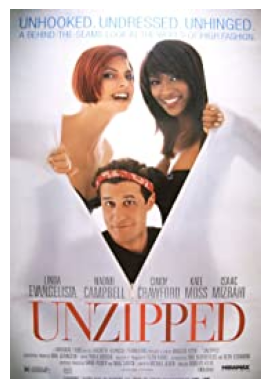

In [5]:
# 检查预处理完成后海报和简介数据的索引是否能够对应
index_for_test = random.randint(0, len(all_posters_index) - 1)

print(movie_names[index_for_test])
print(movie_intros[index_for_test])

poster = cv2.imread(f'./poster/{all_posters_filename[index_for_test]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()

## 训练集划分

In [6]:
with open('train.txt', 'r') as f:
    lines = f.readlines()
    train_idx = [int(line.strip()) for line in lines]

posters_train = [all_posters_filename[i] for i in train_idx]
posters_test = all_posters_filename.copy()
intros_train = [movie_intros[i] for i in train_idx]
intros_test = movie_intros.copy()

# Here elements in posters_train and posters_test are actually filenames, not vectors
print(len(posters_train), len(posters_test), len(intros_train), len(intros_test))

1762 2938 1762 2938


## 搭建pytorch数据集

以下只是一种可能的写法
- 如果之前已经完成了对海报和简介数据的预处理工作，那么就可以不需要这里的`process_poster`和`process_intro`函数
- 如果之前已经将海报数据全部读入，那么就无需再在`Dataset`类中写一次读取图片的操作（对于小数据集可以这样做，但是对于大型的数据集，全部读进来通常是存不下的，因此更推荐在继承的`Dataset`或者`DataLoader`中实现按需读取和预处理）
- ......

In [7]:
import torchvision.transforms as transforms
from torchvision import models
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from transformers import ViTModel, ViTFeatureExtractor

cache_dir = './hub'
class MovieLensDataset(Dataset):
    def __init__(self, data_root, posters, intros, **kwargs):
        self.data_root = data_root
        self.posters = posters
        self.intros = intros
        self.image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224',  cache_dir=cache_dir)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.posters)
    
    def process_poster(self, path):
        poster = cv2.imread(path)
        poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
        # poster = self.transform(poster)
        poster = self.image_processor(images=poster, return_tensors='pt')['pixel_values'].squeeze(0)
        return poster
    
    
    def process_intro(self, intro):
        tokens = self.tokenizer(intro, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0)
    
    def __getitem__(self, index):
        poster = self.process_poster(os.path.join(self.data_root, self.posters[index]))
        input_ids, attention_mask = self.process_intro(self.intros[index])
        return poster, input_ids, attention_mask


data_root = './poster'
dataset_train = MovieLensDataset(
    data_root=data_root,
    posters=posters_train,
    intros=intros_train,
)
dataset_test = MovieLensDataset(
    data_root=data_root,
    posters=posters_test,
    intros=intros_test,
)

/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=8)

In [9]:
import numpy as np

# 迭代DataLoader并查看数据
for posters, input_ids, attention_mask in train_dataloader:
    print("Intros:", input_ids)  # 打印简介文本
    print("intros shape:", input_ids.shape)
    print("Posters shape:", posters.shape)  # 打印海报张量的形状
    print("posters: ", posters)
    # 只查看一个批次
    break

Intros: tensor([[  101,  1996,  2601,  ...,     0,     0,     0],
        [  101,  2238,  3918,  ...,     0,     0,     0],
        [  101,  1996,  2466,  ...,     0,     0,     0],
        ...,
        [  101,  1037, 17718,  ...,     0,     0,     0],
        [  101,  2004,  2027,  ...,     0,     0,     0],
        [  101, 10589, 14163,  ...,     0,     0,     0]])
intros shape: torch.Size([32, 128])
Posters shape: torch.Size([32, 3, 224, 224])
posters:  tensor([[[[-0.8745, -0.9059, -0.9373,  ..., -0.9765, -0.9686, -0.9608],
          [-0.8745, -0.9059, -0.9373,  ..., -0.9765, -0.9686, -0.9608],
          [-0.8745, -0.9059, -0.9373,  ..., -0.9765, -0.9686, -0.9608],
          ...,
          [-0.8902, -0.7333, -0.6549,  ..., -0.5686, -0.8431, -0.8980],
          [-0.8353, -0.6549, -0.5373,  ..., -0.6627, -0.9059, -0.9216],
          [-0.9294, -0.7412, -0.6627,  ..., -0.7569, -0.9451, -0.9137]],

         [[-0.8667, -0.8980, -0.9294,  ..., -0.9686, -0.9608, -0.9529],
          [-0.8667

## 定义模型

In [10]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_distances


class MyModel(nn.Module):
    def __init__(self, hidden_dim):
        super(MyModel, self).__init__()
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224', cache_dir=cache_dir)
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.image_fc = nn.Sequential(
            nn.Linear(self.image_encoder.config.hidden_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.text_fc = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_encoder(pixel_values=images).pooler_output
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        image_features = self.image_fc(image_features)
        text_features = self.text_fc(text_features)
        return image_features, text_features
    
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

    def forward(self, image_features, text_features):
        batch_size = image_features.size(0)
        image_features = nn.functional.normalize(image_features, dim=1)
        text_features = nn.functional.normalize(text_features, dim=1)
        labels = torch.arange(batch_size).long().to(image_features.device)
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * torch.matmul(image_features, text_features.T)
        logits_per_text = logit_scale * torch.matmul(text_features, image_features.T)
        loss_i2t = nn.CrossEntropyLoss()(logits_per_image, labels)
        loss_t2i = nn.CrossEntropyLoss()(logits_per_text, labels)
        return (loss_i2t + loss_t2i) / 2
    
def compute_distance_matrix(image_features, text_features):
    image_features = nn.functional.normalize(image_features, dim=1)
    text_features = nn.functional.normalize(text_features, dim=1)
    distance_matrix = cosine_distances(image_features.detach().cpu().numpy(), text_features.detach().cpu().numpy())
    # print(distance_matrix.shape)
    return torch.tensor(distance_matrix, device=image_features.device)

def get_acc(D, ratio=0.05, dim=1):
    '''
    Calculate the accuracy based on the top-k nearest neighbors in the distance matrix.

    Parameters:
    D : torch.Tensor
        The distance matrix with shape (N, N), where 
        D[i, j] represents the distance between poster[i] and intro[j].
    ratio : float
        A float in the range (0, 1) that determines the proportion of nearest neighbors to consider. 
    dim : int
        The dimension along which to compute the top-k neighbors. 
        Use dim=1 for top-k intros for each poster, dim=0 for the top-k posters for each intro.
    '''

    total_samples = len(D)
    k = int(ratio * total_samples)

    _, topk_indices = D.topk(k, dim=dim, largest=False)
    if dim == 0:
        topk_indices = topk_indices.T
    
    correct_matches = 0
    for i in range(total_samples):
        if i in topk_indices[i]:
            correct_matches += 1
    accuracy = correct_matches / total_samples
    return accuracy


## 模型训练

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hidden_dim = 256  # 隐藏层维度

model = MyModel(hidden_dim).to(device)
print(model)
criterion = NTXentLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

num_epochs = 70
train_dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)

best_acc =0.0
best_model_path = './bestmodel_vit.pth'
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for posters, input_ids, attention_mask in train_dataloader:
        posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
        
        image_features, text_features = model(posters, input_ids, attention_mask)
        
        loss = criterion(image_features, text_features)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss / len(train_dataloader))
    
    # 计算距离矩阵和准确率
    model.eval()
    all_image_features = []
    all_text_features = []
    with torch.no_grad():
        for posters, input_ids, attention_mask in test_dataloader:
            posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
            image_features, text_features = model(posters, input_ids, attention_mask)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
    
    # 拼接所有特征
    all_image_features = torch.cat(all_image_features, dim=0)
    # print(all_image_features.shape)
    all_text_features = torch.cat(all_text_features, dim=0)
    # print(all_text_features.shape)
    
    # 计算距离矩阵
    distance_matrix = compute_distance_matrix(all_image_features, all_text_features)
    acc_dim0 = get_acc(distance_matrix, ratio=0.05, dim=0)
    acc_dim1 = get_acc(distance_matrix, ratio=0.05, dim=1)
    
    avg_acc = (acc_dim0 + acc_dim1) / 2
    
    if avg_acc > best_acc:
        best_acc = avg_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with accuracy: {best_acc * 100:.2f}%')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}, Accuracy Dim 0: {acc_dim0 * 100:.2f}%, Accuracy Dim 1: {acc_dim1 * 100:.2f}%')
print("Training finished!")

cuda


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MyModel(
  (image_encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

## 模型测试

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 256
model = MyModel(hidden_dim).to(device)
best_model_path = './bestmodel_vit.pth'
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_image_features = []
all_text_features = []
with torch.no_grad():
    for posters, input_ids, attention_mask in test_dataloader:
        posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
        image_features, text_features = model(posters, input_ids, attention_mask)
        all_image_features.append(image_features)
        all_text_features.append(text_features)

all_image_features = torch.cat(all_image_features, dim=0)
all_text_features = torch.cat(all_text_features, dim=0)

distance_matrix = compute_distance_matrix(all_image_features, all_text_features)
acc_dim0 = get_acc(distance_matrix, ratio=0.05, dim=0)
acc_dim1 = get_acc(distance_matrix, ratio=0.05, dim=1)
sum_acc = acc_dim0 + acc_dim1
print(f'The acc of the best model is: acc_dim0: {acc_dim0} acc_dim1: {acc_dim1} sum: {sum_acc}')

The acc of the best model is: acc_dim0: 0.6664397549353301 acc_dim1: 0.6827773995915589 sum: 1.349217154526889


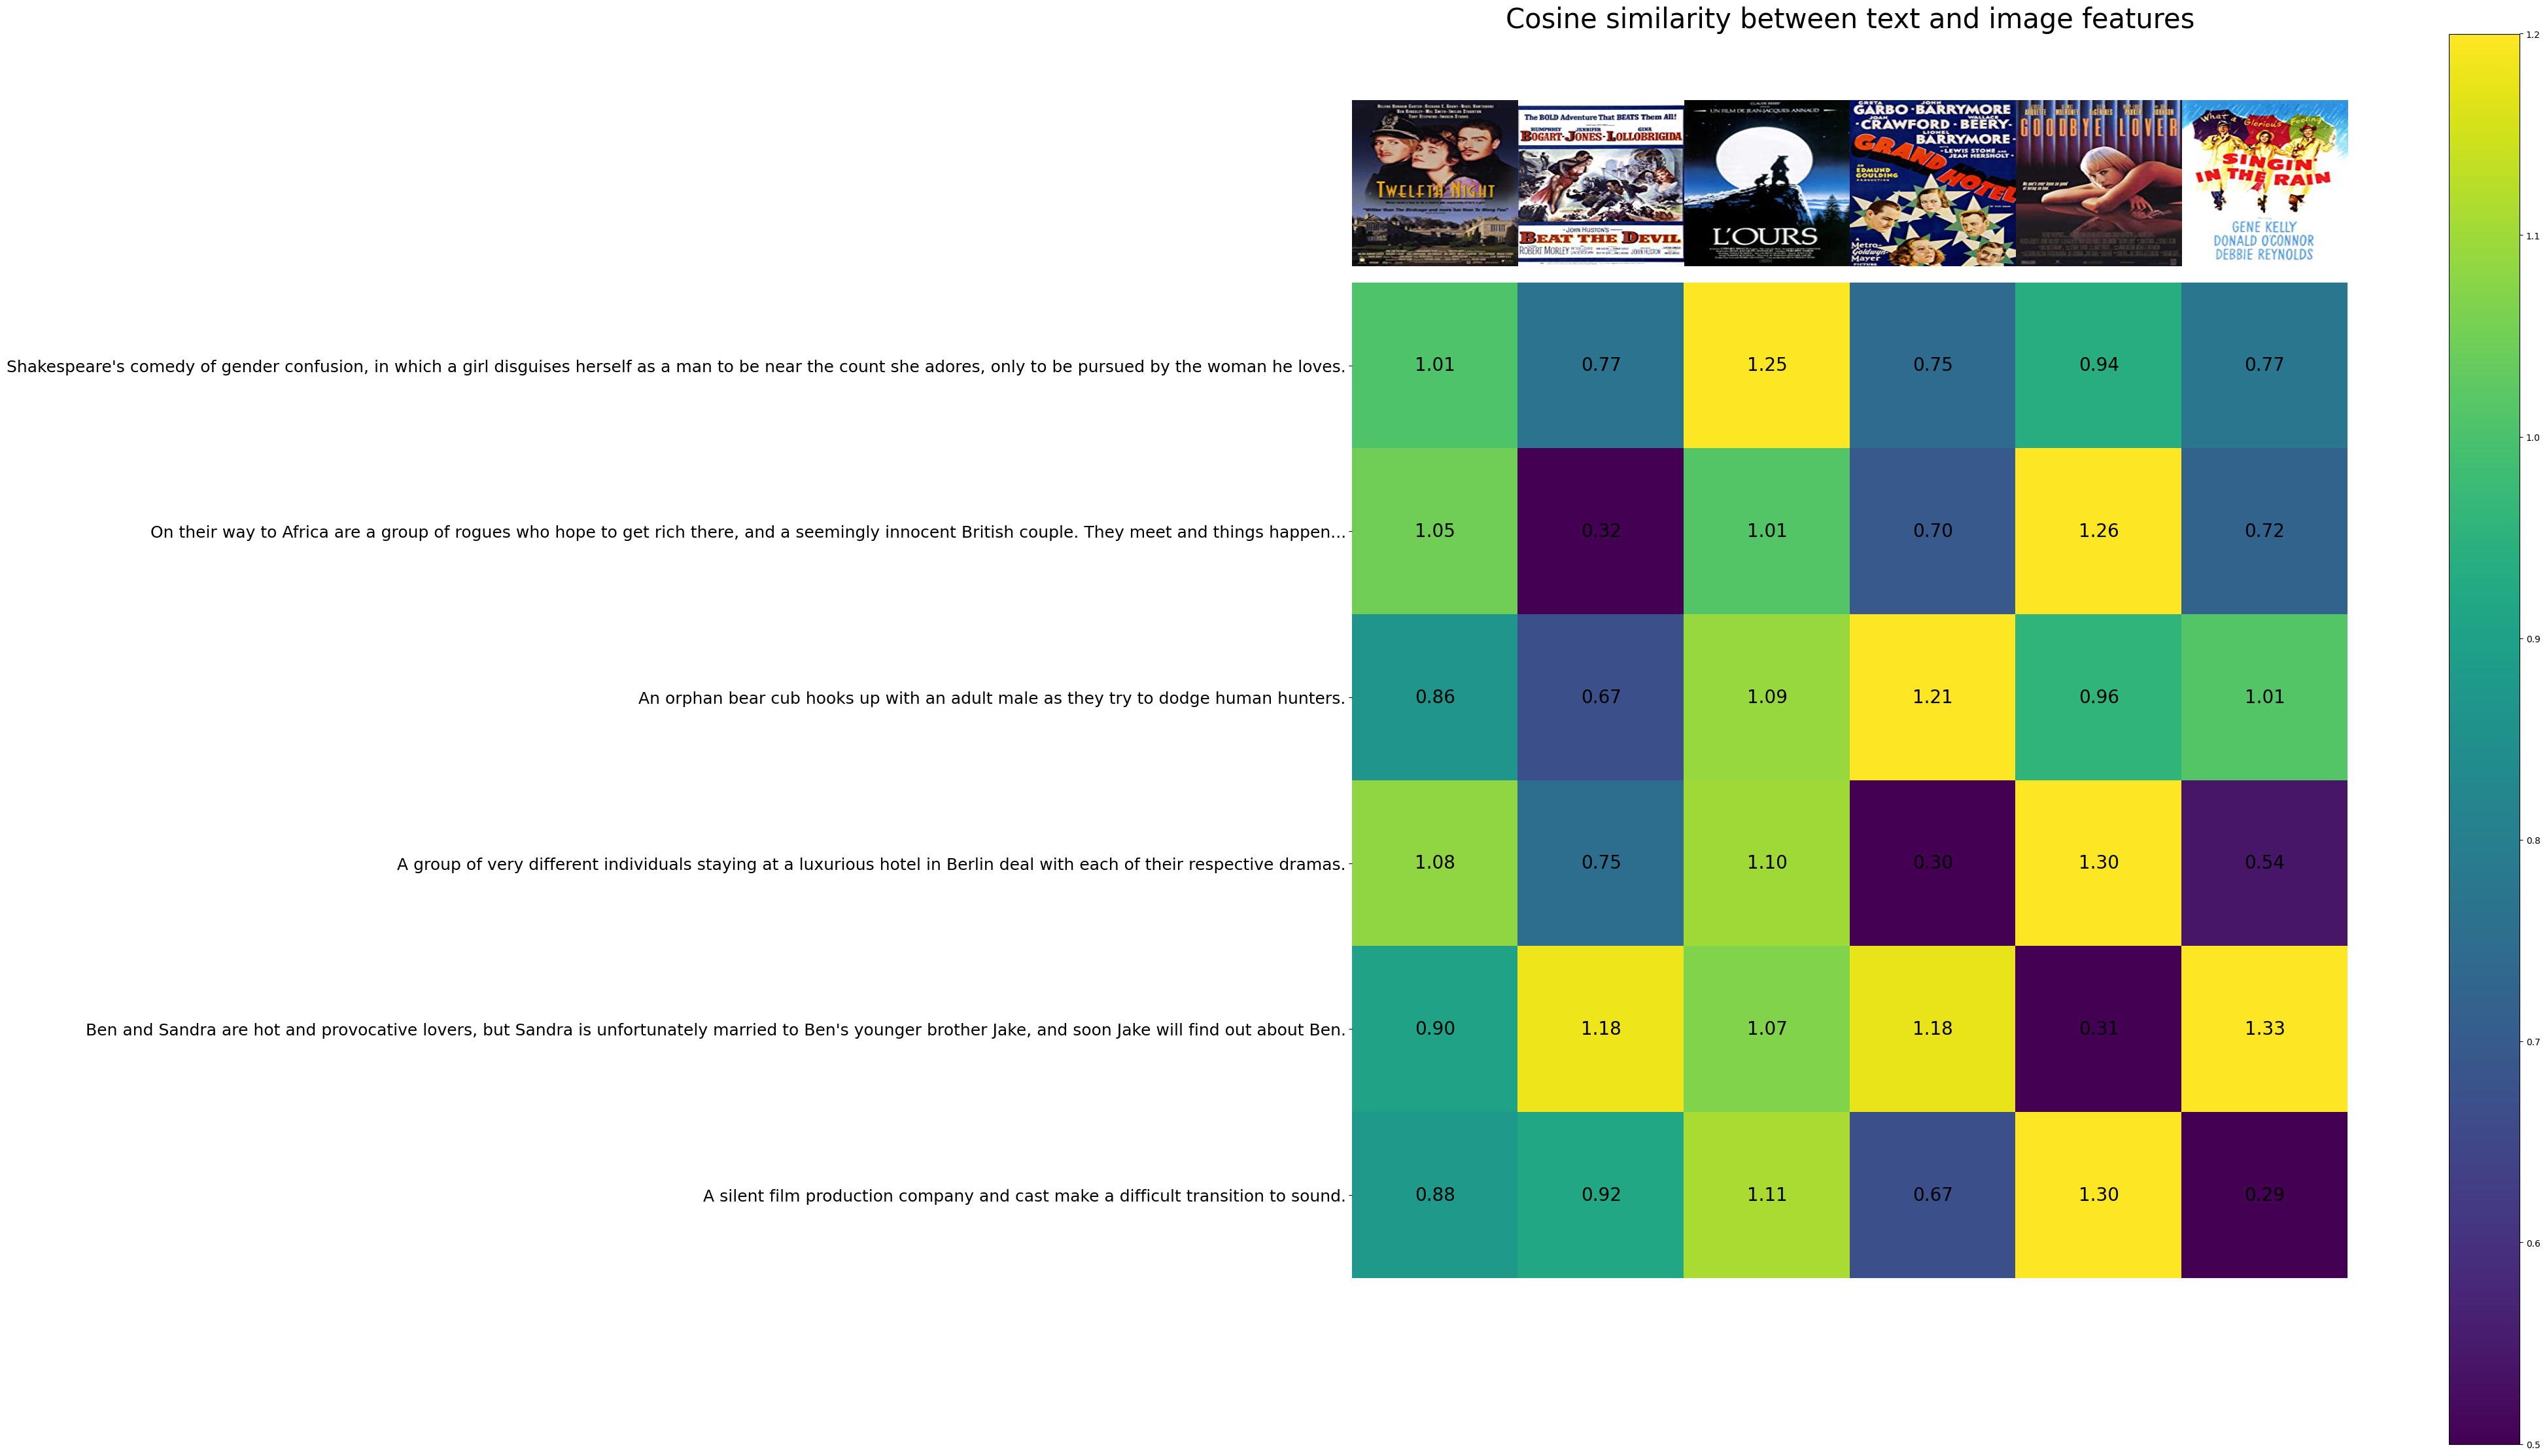

Movie Name: Twelfth Night or What You Will (1996) 
Movie Intro: Shakespeare's comedy of gender confusion, in which a girl disguises herself as a man to be near the count she adores, only to be pursued by the woman he loves.


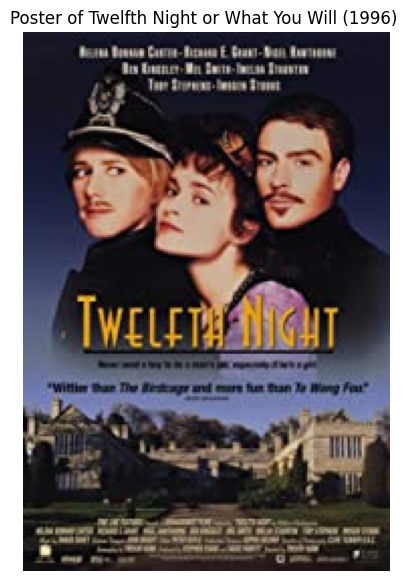

Movie Name: Beat the Devil (1953) 
Movie Intro: On their way to Africa are a group of rogues who hope to get rich there, and a seemingly innocent British couple. They meet and things happen...


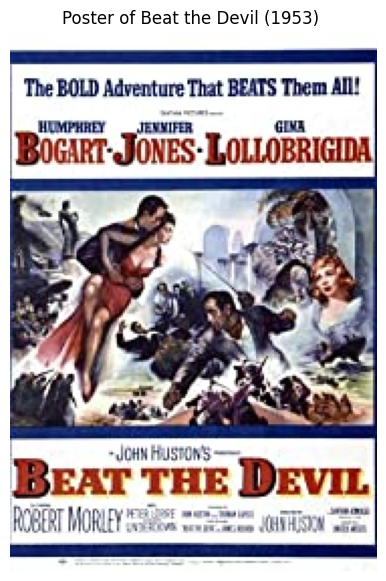

Movie Name: L'ours (1988) 
Movie Intro: An orphan bear cub hooks up with an adult male as they try to dodge human hunters.


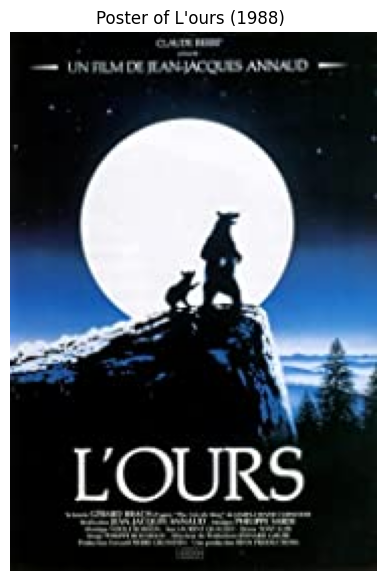

Movie Name: Grand Hotel (1932) 
Movie Intro: A group of very different individuals staying at a luxurious hotel in Berlin deal with each of their respective dramas.


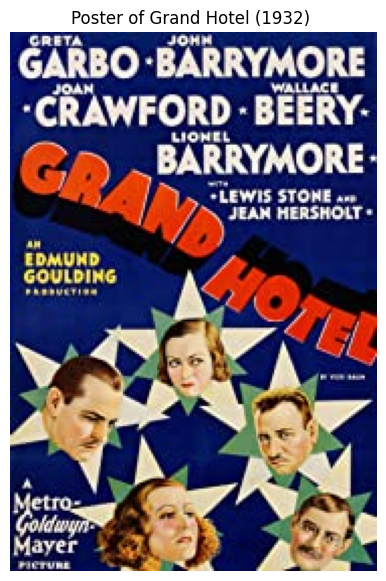

Movie Name: Goodbye Lover (1998) 
Movie Intro: Ben and Sandra are hot and provocative lovers, but Sandra is unfortunately married to Ben's younger brother Jake, and soon Jake will find out about Ben.


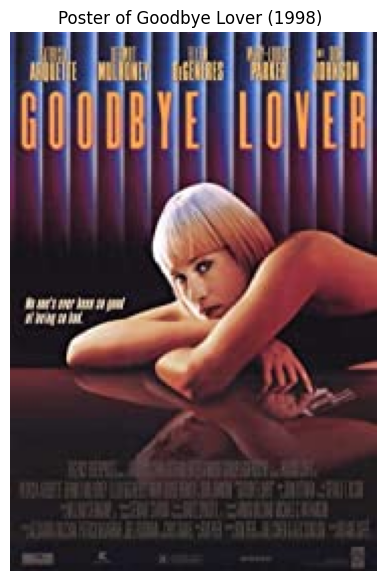

Movie Name: Singin' in the Rain (1952) 
Movie Intro: A silent film production company and cast make a difficult transition to sound.


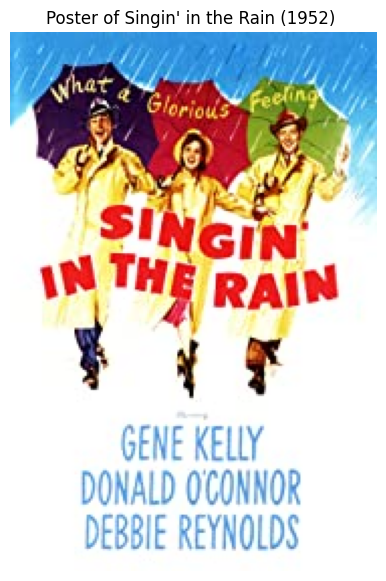

In [13]:
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

distance_matrix_np = distance_matrix.cpu().numpy()

selected_indices = random.sample(range(len(movie_names)), 6)
sub_distance_matrix = distance_matrix_np[selected_indices][:, selected_indices]

original_images = []
for index in selected_indices:
    filename = f'./poster/{all_posters_filename[index]}'
    image = Image.open(os.path.join(filename)).convert("RGB")
    original_images.append(image)

count = len(selected_indices)
texts = [movie_intros[i] for i in selected_indices]
plt.figure(figsize=(40, 28))
plt.imshow(sub_distance_matrix, vmin=0.5, vmax=1.2)
plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(sub_distance_matrix.shape[1]):
    for y in range(sub_distance_matrix.shape[0]):
        plt.text(x, y, f"{sub_distance_matrix[y, x]:.2f}", ha="center", va="center", size=20)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=30)
plt.show()

# 显示对应的海报图片和简介
for index in selected_indices:
    print("Movie Name:", movie_names[index])
    print("Movie Intro:", movie_intros[index])

    # 读取并显示对应的海报
    poster = cv2.imread(f'./poster/{all_posters_filename[index]}')
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 7))
    plt.imshow(poster)
    plt.axis('off')
    plt.title(f"Poster of {movie_names[index]}")
    plt.show()

movie name: Singin' in the Rain (1952) 
movie intro: A silent film production company and cast make a difficult transition to sound.


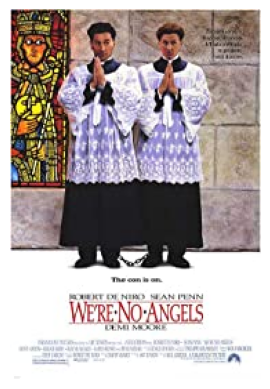

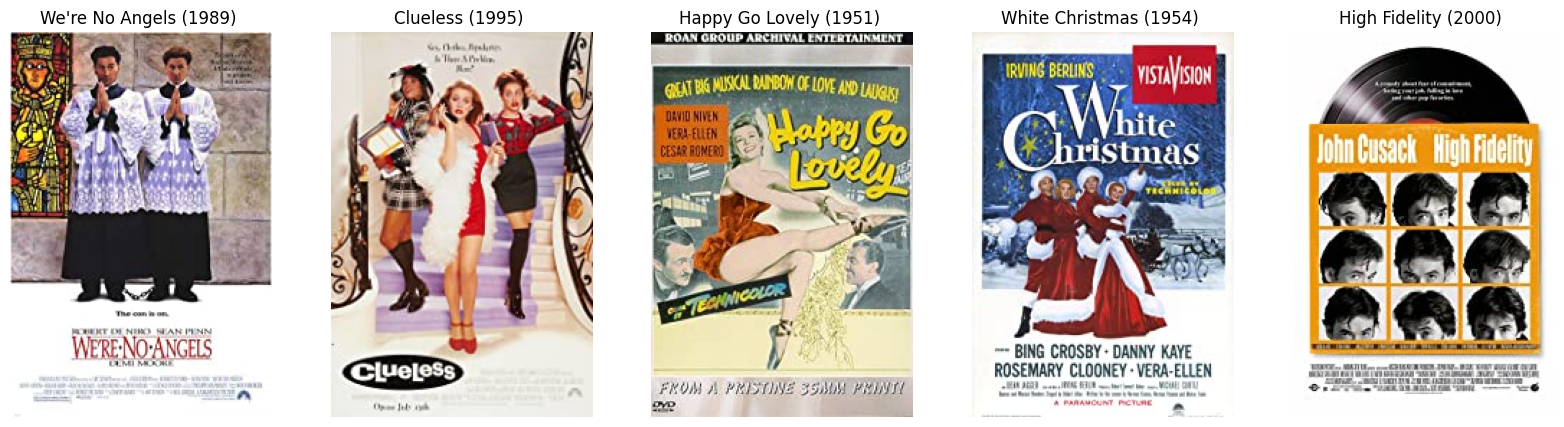

In [14]:
index_1 = random.randint(0, len(movie_names))
total_samples = len(distance_matrix)
_, topk_indices_1 = distance_matrix.topk(5, dim=1, largest=False)
print(f'movie name: {movie_names[index_1]}')
print(f'movie intro: {movie_intros[index_1]}')
poster = cv2.imread(f'./poster/{all_posters_filename[index_1]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in zip(topk_indices_1[index_1, :], axes):
    i = i.item()  # 将张量转换为整数
    poster = cv2.imread(f'./poster/{all_posters_filename[i]}')
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    ax.imshow(poster)
    ax.axis('off')
    ax.set_title(movie_names[i])

plt.show()

movie name: Seong lung wui (1992) 
movie intro: Identical twins are separated at birth, one becoming a streetwise mechanic, and the other an acclaimed classical concert conductor. Finally meeting in adulthood, they each become mistaken for the other and entangled in each other's world.


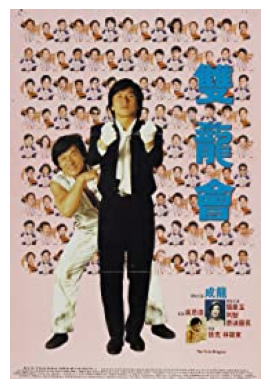

Identical twins are separated at birth, one becoming a streetwise mechanic, and the other an acclaimed classical concert conductor. Finally meeting in adulthood, they each become mistaken for the other and entangled in each other's world.
The true story of a heroic man, Hunter "Patch" Adams, determined to become a medical doctor because he enjoys helping people. He ventured where no doctor had ventured before, using humour and pathos.
A temperamental figure skater and a former hockey player try to win Olympic gold as a figure skating pairs team.
Lovers' lives are complicated by city law, feuding faerie royalty, and... love.
The events focus around a crisis hotline business on one crazy night during the Christmas holidays.


In [15]:
index = random.randint(0, len(movie_names))
total_samples = len(distance_matrix)
_, topk_indices_0 = distance_matrix.topk(5, dim=0, largest=False)
print(f'movie name: {movie_names[index]}')
print(f'movie intro: {movie_intros[index]}')
poster = cv2.imread(f'./poster/{all_posters_filename[index]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()
for i in topk_indices_0[:, index]:
    print(movie_intros[i])